# 1. Import required libs

In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

# 2. Build train and test sets

## 2.1. Load raw data

In [2]:
data_path = 'data/bci-iv-2a/A0'
def load_data(data_path):
    X_train = np.load(f'{data_path}1T_X.npy')
    y_train = np.load(f'{data_path}1T_Y.npy')
    X_test = np.load(f'{data_path}1E_X.npy')
    y_test = np.load(f'{data_path}1E_Y.npy')

    for i in range(2, 10, 1):
        xt = np.load(f'{data_path}{i}T_X.npy')
        yt = np.load(f'{data_path}{i}T_Y.npy')
        xv = np.load(f'{data_path}{i}E_X.npy')
        yv = np.load(f'{data_path}{i}E_Y.npy')
        
        X_train = np.concatenate([X_train, xt])
        y_train = np.concatenate([y_train, yt])
        X_test = np.concatenate([X_test, xv])
        y_test = np.concatenate([y_test, yv])
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = load_data(data_path)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (2592, 22, 1875)
y_train shape:  (2592,)
X_test shape:  (2592, 22, 1875)
y_test shape:  (2592,)


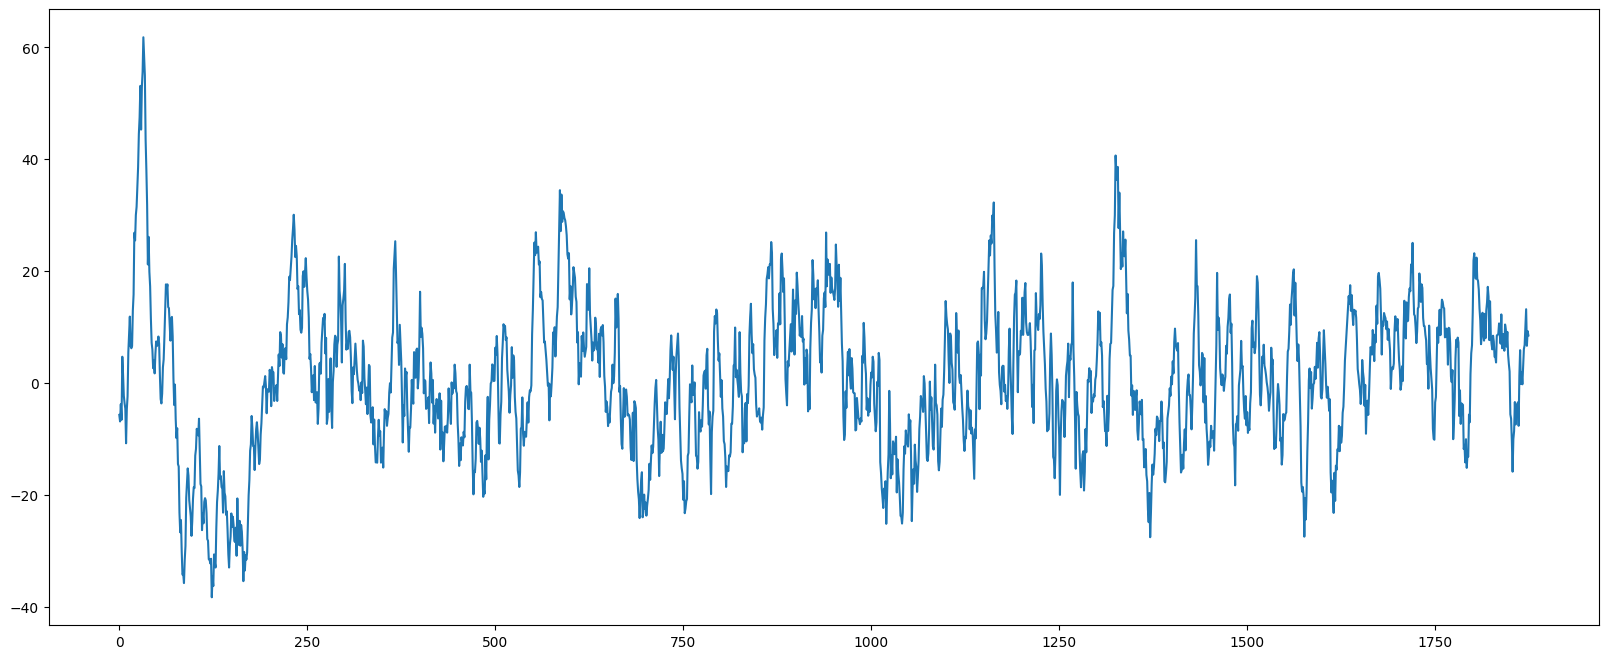

In [4]:
# Plot a channel in a sample
plotter = X_train[0][0]
plt.figure(figsize=(20, 8))
plt.plot(plotter)

## 2.2. Transform data

In [5]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [6]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (2592, 41250)
y_train shape:  (2592,)
X_test shape:  (2592, 41250)
y_test shape:  (2592,)


# 3. Train and Evaluate Model

## 3.1 Define train and eval

In [7]:
def cross_val_model(model, X_train, y_train, n_splits=10):
    kfold = KFold(n_splits=n_splits, random_state=42, shuffle=True)

    results = cross_validate(estimator=model,
                                X=X_train,
                                y=y_train,
                                cv=kfold,
                                scoring='f1_macro')
        
    return results
    

In [8]:
def train_and_eval_model(model, X_train, X_test, y_train, y_test):
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    labels = list(range(4))
    names = ['left-hand', 'right-hand', 'legs', 'tongle']
    
    report = classification_report(y_pred=y_pred, y_true=y_test, labels=labels, target_names=names)
    
    return model, report

In [9]:
# Define model
svm_clf = SVC(kernel='rbf', C=10, gamma='scale')

In [10]:
results = cross_val_model(svm_clf, X_train, y_train, n_splits=5)
print(results)

{'fit_time': array([124.31701636, 127.96338654, 130.29786491, 121.42846966,
       119.28094482]), 'score_time': array([59.12803721, 64.89592767, 56.08627892, 59.26929092, 57.38970566]), 'test_score': array([0.39384439, 0.36211221, 0.37043381, 0.38147484, 0.38792067])}


In [11]:
svm_trained, report = train_and_eval_model(svm_clf, X_train, X_test, y_train, y_test)

## 3.2. Tuning hyper-parameters

In [12]:
# Define hyper-parameters
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 'scale'], 'kernel': ['rbf']}

# Finding best params
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=3)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 3.0min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 2.9min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 2.8min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 3.0min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 3.3min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 3.5min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 2.9min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 3.0min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time= 3.3min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time= 3.0min
[CV] END ........................C=1, gamma=0.01,

# 4. Xgboost classifier

In [13]:
params = {
    'tree_method': 'approx',
    'objective': 'multi:softprob',
}
num_boost_round = 10

xgb_clf = XGBClassifier(n_estimators=num_boost_round, **params)

In [14]:
results = cross_val_model(xgb_clf, X_train, y_train, n_splits=5)
print(results)

{'fit_time': array([796.36409378, 908.96825933, 892.67679262, 875.18750405,
       855.68918395]), 'score_time': array([0.24021626, 0.21450043, 0.2137785 , 0.20229363, 0.2501781 ]), 'test_score': array([0.32497006, 0.32178576, 0.35786798, 0.35912739, 0.31506769])}


In [16]:
xgb_trained, report = train_and_eval_model(xgb_clf, X_train, X_test, y_train, y_test)
print(report)

              precision    recall  f1-score   support

   left-hand       0.30      0.29      0.30       648
  right-hand       0.32      0.33      0.33       648
        legs       0.39      0.42      0.40       648
      tongle       0.40      0.38      0.39       648

    accuracy                           0.35      2592
   macro avg       0.35      0.35      0.35      2592
weighted avg       0.35      0.35      0.35      2592

